In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

In [2]:
# df = pd.read_csv("/content/spam.csv", encoding="utf-8")
df = pd.read_csv("/content/spam.csv", encoding="latin-1")


In [3]:
df.shape

(5572, 5)

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
new_df = df[["v1", "v2"]]

In [6]:
new_df.shape

(5572, 2)

In [7]:
new_df["v2"].iloc[35]

'Yup... Ok i go home look at the timings then i msg Ì_ again... Xuhui going to learn on 2nd may too but her lesson is at 8am'

In [8]:
new_df.isna().sum()

,0
v1,0
v2,0


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [11]:
def preprocessing(data):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    def clean_sentence(sentence):
        # Convert to lowercase
        sentence = sentence.lower()

        # Remove non-alphanumeric characters
        sentence = re.sub("[^a-z0-9]", " ", sentence)

        # Remove URLs
        sentence = re.sub(r'(http|https|ftp|ssh)://[\w_-]+(?:\.[\w_-]+)+[\w.,@?^=%&/~+#-]*[\w@?^=%&/~+#-]?', '', sentence)

        # Remove stopwords
        sentence = " ".join([word for word in sentence.split() if word not in stop_words])

        # Clean any potential HTML tags
        sentence = BeautifulSoup(sentence, "lxml").get_text()

        # Lemmatize words
        sentence = " ".join([lemmatizer.lemmatize(word) for word in sentence.split()])

        return sentence

    # Apply the cleaning function to each row
    data['v2'] = data['v2'].apply(clean_sentence)

    return data

In [12]:
cleaned_data = preprocessing(new_df)

<ipython-input-11-3402c3d3f8bc>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['v2'] = data['v2'].apply(clean_sentence)


In [13]:
cleaned_data.head()

,v1,v2
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though


In [14]:
def vocabulary(data):
  words = [word for sentence in data["v2"] for word in sentence.split()]
  word_counts = Counter(words)
  sorted_word_counts = word_counts.most_common()
  return sorted_word_counts

In [15]:
word_counts = vocabulary(cleaned_data)

In [16]:
def remove_words(word_counts):

  outliers = []
  for i, (w, c) in enumerate(word_counts):           ## Time Complexity is O(n)
    if c<2:
      outliers.append(w)
  word_counts = [word for word in word_counts if word[0] not in outliers]

  return word_counts

In [17]:
cleaned_word_counts = remove_words(word_counts)

In [18]:
def vocab_to_int(word_counts):
  word_to_int = {}
  for i, (w, c) in enumerate(word_counts):
    word_to_int[w] = i+1

  return word_to_int

In [19]:
word_to_int = vocab_to_int(cleaned_word_counts)

In [20]:
def sentence_to_numeric(sentence, word_to_int):
  numeric_sentence = [word_to_int[word] for word in sentence.split() if word in word_to_int]

  return numeric_sentence

In [21]:
text_to_numeric = cleaned_data["v2"].apply(lambda sentence: sentence_to_numeric(sentence, word_to_int))

In [22]:
text_to_numeric

,v2
0,"[9, 282, 612, 525, 1140, 38, 64, 236, 1141, 80..."
1,"[10, 248, 1306, 362, 1, 1691]"
2,"[11, 373, 3, 646, 741, 99, 1692, 1028, 526, 16..."
3,"[1, 158, 60, 283, 2660, 1, 31, 85, 60]"
4,"[860, 44, 9, 799, 90, 138, 363]"
...,...
5567,"[325, 17, 440, 3, 121, 1, 1, 513, 364, 82, 3, ..."
5568,"[91, 29, 1781, 662, 30]"
5569,"[1137, 3956]"
5570,"[137, 3903, 15, 1074, 952, 123, 417, 132, 47, ..."


In [23]:
len(text_to_numeric[0])

14

In [24]:
labels = cleaned_data["v1"]

In [25]:
labels

,v1
0,ham
1,ham
2,spam
3,ham
4,ham
...,...
5567,spam
5568,ham
5569,ham
5570,ham


In [26]:
text_to_numeric_data = pd.DataFrame(text_to_numeric, columns=["v2"])

In [27]:
text_to_numeric_data["label"] = labels

In [28]:
text_to_numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v2      5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [29]:
text_to_numeric_data.head()

,v2,label
0,"[9, 282, 612, 525, 1140, 38, 64, 236, 1141, 80...",ham
1,"[10, 248, 1306, 362, 1, 1691]",ham
2,"[11, 373, 3, 646, 741, 99, 1692, 1028, 526, 16...",spam
3,"[1, 158, 60, 283, 2660, 1, 31, 85, 60]",ham
4,"[860, 44, 9, 799, 90, 138, 363]",ham


In [30]:
text_to_numeric_data['label'] = text_to_numeric_data['label'].map({'ham': 0, 'spam': 1})

# text_to_numeric_data["v2"] = text_to_numeric_data["v2"].apply(lambda x: np.array(x))

In [31]:
def text_length(data):
  data["draft_length"] = data["v2"].apply(lambda x: len(x))

  return data

In [32]:
new_cleaned_data = text_length(text_to_numeric_data)

In [33]:
new_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   v2            5572 non-null   object
 1   label         5572 non-null   int64 
 2   draft_length  5572 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 130.7+ KB


In [34]:
def boxplot(data):

  plt.figure(figsize=(12, 5))
  sns.boxplot(data["draft_length"])
  plt.show()

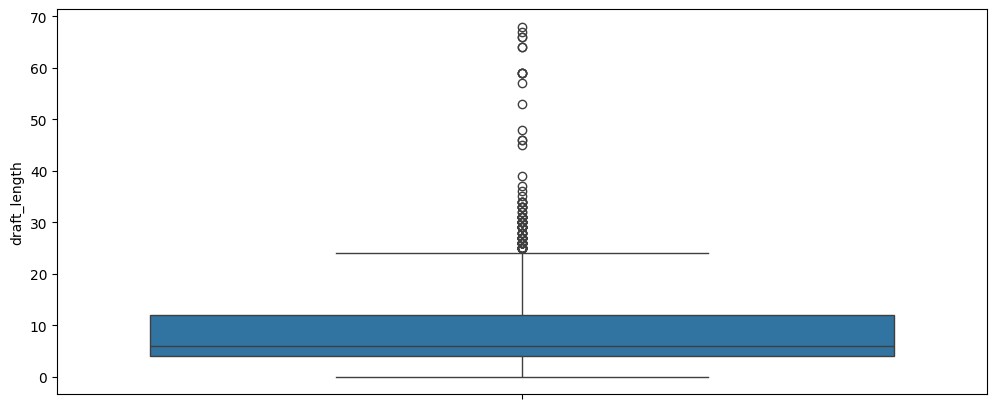

In [35]:
boxplot(new_cleaned_data)

In [36]:
len(new_cleaned_data[new_cleaned_data["draft_length"]>30])

41

In [37]:
def remove_outliers(data, col):

  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)

  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  data = data.reset_index(drop=True)
  data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

  return data

In [38]:
new_cleaned_data = remove_outliers(new_cleaned_data, "draft_length")

In [39]:
new_cleaned_data.head()

,v2,label,draft_length
0,"[9, 282, 612, 525, 1140, 38, 64, 236, 1141, 80...",0,14
1,"[10, 248, 1306, 362, 1, 1691]",0,6
3,"[1, 158, 60, 283, 2660, 1, 31, 85, 60]",0,9
4,"[860, 44, 9, 799, 90, 138, 363]",0,7
5,"[647, 69, 1143, 75, 47, 139, 40, 15, 296, 36, ...",1,18


In [40]:
new_cleaned_data.shape

(5451, 3)

In [41]:
import numpy as np

def padding(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype=int)  # Initialize with zeros

    for i, sentence in enumerate(sentences):
        if len(sentence) > 0:  # Ensure sentence is not empty
            features[i, -len(sentence):] = np.array(sentence)[:seq_length]

    return features


In [42]:
padded_training_data = padding(new_cleaned_data["v2"], 28)

In [43]:
padded_training_data.shape

(5451, 28)

In [44]:
padded_training_data

array([[   0,    0,    0, ..., 1142,   18,   71],
       [   0,    0,    0, ...,  362,    1, 1691],
       [   0,    0,    0, ...,   31,   85,   60],
       ...,
       [   0,    0,    0, ...,    0, 1137, 3956],
       [   0,    0,    0, ...,  874,    1,   11],
       [   0,    0,    0, ..., 2370,  359,  164]])

In [45]:
def np_labels(label_data):
  labels = np.array(label_data)

  return labels

In [46]:
np_labels = np_labels(new_cleaned_data["label"])

In [47]:
train_inputs, test_inputs, train_tragets, test_targets = train_test_split(padded_training_data, np_labels, test_size=0.2, random_state=42)

In [48]:
rf_model = RandomForestClassifier(n_estimators=120, random_state=369)

In [49]:
rf_model.fit(train_inputs, train_tragets)

RandomForestClassifier(n_estimators=120, random_state=369)

In [50]:
rf_model.score(test_inputs, test_targets)

0.9248395967002749